In [28]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import mplfinance as mpf
print(os.getcwd())

c:\Users\jenny\Desktop


In [2]:
os.chdir('台指期資料庫')
os.getcwd()


'c:\\Users\\jenny\\Desktop\\台指期資料庫'

In [ ]:
flist = [f for f in os.listdir() if f.split(".")[-1] == "csv"]
list_ = []
for f in tqdm(flist[:], desc=f"csv concat for total of {len(list_)}"):
    df = pd.read_csv(f)
    list_.append(df)
df_final = pd.concat(list_)
df_final = pd.concat(list_, ignore_index=True)

print(df_final)


#分離日期、時間
def create_da_time_column(row, create='da'):
   da, time = row['Date'].split(" ")
   return da if create == 'da' else time
df_final['da'] = df_final.apply(create_da_time_column, axis=1, args=('da',))
df_final['time'] = df_final.apply(create_da_time_column, axis=1, args=('time',))

In [4]:
if 'Date' in df_final.columns:
  df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final.to_parquet("TW_index.parquet")

In [5]:
df = pd.read_parquet("TW_index.parquet")

In [6]:
# 使用函數計算波段高低點
def find_peaks_and_troughs(df, window_size=60):
    df['High_Rolling'] = df['High'].rolling(window=window_size, center=False).max()
    df['Low_Rolling'] = df['Low'].rolling(window=window_size, center=False).min()

    df['Peak'] = np.where(df['High'] == df['High_Rolling'], df['High'], np.nan)
    df['Trough'] = np.where(df['Low'] == df['Low_Rolling'], df['Low'], np.nan)
    
    return df

find_peaks_and_troughs(df, window_size=60)
df.drop(columns=['High_Rolling', 'Low_Rolling'], inplace=True)

In [64]:
#新增判斷欄位，確認Peak、Trough是否有值
df['Judge_Peak'] = df['Peak'].apply(lambda x: False if pd.isna(x) else bool(x))
df['Judge_Trough'] = df['Trough'].apply(lambda x: False if pd.isna(x) else bool(x))

In [ ]:
start_checking = False
index_peak = None
start_checking = False
df['peaks'] = 0
#for index in tqdm(range(len(df)-1, -1, -1), desc="Checking peaks"):
for index in range (len(df)-1, -1, -1):
    # check for the first peak
    if not start_checking:
        if df.iloc[index, :]['Judge_Peak']:
            start_checking = True
            index_peak = index
    # consecutive peaks
    else:
        if df.iloc[index, :]['Judge_Peak'] and start_checking:
            index_peak = index
        elif not df.iloc[index, :]['Judge_Peak'] and not df.iloc[index, :]['Judge_Trough']:
            pass
        elif df.iloc[index, :]['Judge_Trough'] and start_checking:
            print(f"Trough found at index {index}, setting peak at index {index_peak}")  
            df.at[index_peak, 'peaks'] = 1
            index_peak = None
            start_checking = False


In [ ]:
start_checking = False
index_trough = None
start_checking = False
df['troughs'] = 0
#for index in tqdm(range(len(df)-1, -1, -1), desc="Checking peaks"):
for index in range (len(df)-1, -1, -1):
    # check for the first peak
    if not start_checking:
        if df.iloc[index, :]['Judge_Trough']:
            start_checking = True
            index_trough = index
    # consecutive peaks
    else:
        if df.iloc[index, :]['Judge_Trough'] and start_checking:
            index_trough = index
        elif not df.iloc[index, :]['Judge_Trough'] and not df.iloc[index, :]['Judge_Peak']:
            pass
        elif df.iloc[index, :]['Judge_Peak'] and start_checking:
            print(f"True found at index {index}, setting trough at index {index_trough}")  
            df.at[index_trough, 'troughs'] = 1
            index_trough = None
            start_checking = False

In [10]:
df['Peak_value'] = df.apply(lambda row: row['Peak'] if row['peaks'] == 1 else None, axis=1)
df['Trough_value'] = df.apply(lambda row: row['Trough'] if row['troughs'] == 1 else None, axis=1)

In [11]:
df['Peak_gap'] = df['Peak_value'].ffill().diff()
df['Trough_gap'] = df['Trough_value'].ffill().diff()

df.drop(columns=['Judge_Peak','Judge_Trough'], inplace=True)

In [144]:
#匯出檔案至桌面
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "output.csv")
df. to_csv(file_path, index=True)

In [17]:
#中途加入，匯入新的csv
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "output.csv")
df = pd.read_csv(file_path)

#計算60MA
df['60MA'] = df['Close'].rolling(window=60).mean()
df['60MA'] = df['60MA'].apply(lambda x: int(x) if pd.notna(x) else x)

In [22]:
#計算short_entry
df['short_entry'] = np.nan
df['peak_copy'] = df['Peak_gap']


In [ ]:
for index in range (len(df)-1, -1, -1):
    if (df.iloc[index, :]['peaks'] == 1 and df.iloc[index, :]['Peak_gap'] < 0) :
        index_short = index
        print(f"True found at index {index}, setting short at index {index_short}")  
        df.at[index_short, 'short_entry'] = df.at[index_short,'Peak_value']
    elif (df.iloc[index, :]['peaks'] == 1) and (df.iloc[index, :]['peak_copy'] < 0):
        index_short = index
        print(f"True found at index {index}, setting short at index {index_short}")  
        df.at[index_short, 'short_entry'] = df.at[index_short, 'Peak_value']
        
        # 找到前一個有值的 Peak_value
        for prev_index in range(index - 1, -1, -1):
            if not pd.isna(df.iloc[prev_index]['Peak_value']):
                previous_index_short = prev_index
                df.at[previous_index_short, 'short_entry'] = df.at[previous_index_short, 'Peak_value']
                print(f"Previous valid Peak_value found at index {previous_index_short}, setting short_entry")
                break  # 找到後跳出迴圈
    else:
        df.at[index, 'Peak_value']=None
        start_index = max(0, index - 50000)
        end_index = min(len(df), index + 50000)
        df['Peak_gap'] = df['Peak_value'].ffill().diff()

df.drop(columns=['peak_copy'], inplace=True)


In [19]:
#計算long_entry
df['long_entry'] = np.nan
df['trough_copy'] = df['Trough_gap']

In [ ]:
for index in range(len(df) - 1, -1, -1):
    if (df.iloc[index]['troughs'] == 1 and df.iloc[index]['Trough_gap'] > 0) :
        index_long = index
        print(f"True found at index {index}, setting short at index {index_long}")  
        df.at[index_long, 'long_entry'] = df.at[index_long, 'Trough_value']
    elif (df.iloc[index]['troughs'] == 1 and df.iloc[index]['trough_copy'] > 0):
        index_long = index
        print(f"True found at index {index}, setting short at index {index_long}")  
        df.at[index_long, 'long_entry'] = df.at[index_long, 'Trough_value']
        
        # 找到前一個有值的 Trough_value
        for prev_index in range(index - 1, -1, -1):
            if not pd.isna(df.iloc[prev_index]['Trough_value']):
                previous_index_long = prev_index
                df.at[previous_index_long, 'long_entry'] = df.at[previous_index_long, 'Trough_value']
                print(f"Previous valid Trough_value found at index {previous_index_long}, setting long_entry")
                break  # 找到後跳出迴圈
    else:
        df.at[index, 'Trough_value'] = None
        start_index = max(0, index - 50000)
        end_index = min(len(df), index + 50000)
        df.loc[start_index:end_index, 'Trough_gap'] = df.loc[start_index:end_index, 'Trough_value'].ffill().diff()

df.drop(columns=['trough_copy'], inplace=True)


In [25]:
df['short_gap'] = df['short_entry'].ffill().diff()
df['long_gap'] = df['long_entry'].ffill().diff()

In [14]:
#計算short進場點
valid_indices = df['short_entry'].dropna().index
result = {}

# 遍歷有值的索引，兩兩一組進行計算
for i in range(len(valid_indices) - 1):
    first_idx = valid_indices[i]
    second_idx = valid_indices[i + 1]
    
    # 檢查 second_idx 的 short_gap 是否小於 0
    if df.loc[second_idx, 'short_gap'] < 0:
        sum_value = df.loc[first_idx, 'short_entry'] + (2/3) * df.loc[second_idx, 'short_gap']
        result[second_idx] = sum_value

# 將結果加入 DataFrame 新欄位
df['calculated_short_entry'] = np.nan
df.loc[list(result.keys()), 'calculated_short_entry'] = list(result.values())


In [15]:
#計算long進場點
valid_indices = df['long_entry'].dropna().index
result = {}

# 遍歷有值的索引，兩兩一組進行計算
for i in range(len(valid_indices) - 1):
    first_idx = valid_indices[i]
    second_idx = valid_indices[i + 1]
    
    # 檢查 second_idx 的 long_gap 是否大於 0
    if df.loc[second_idx, 'long_gap'] > 0:
        sum_value = df.loc[first_idx, 'long_entry'] + (2/3) * df.loc[second_idx, 'long_gap']
        result[second_idx] = sum_value

# 將結果加入 DataFrame 新欄位
df['calculated_long_entry'] = np.nan
df.loc[list(result.keys()), 'calculated_long_entry'] = list(result.values())



In [77]:
#多頭進場

# 初始化必要欄位
sellshort = []
buytocover = []
#profit_dict = {}
#profit_fee_dict = {}
#profit_fee_list_realized = []
open_positions = []

feePaid = 40  # 假設每次交易手續費

# 找到符合條件的 valid_indices
valid_indices =[]
valid_indices = df[(df['calculated_short_entry'].notna())].index 

for idx in valid_indices:
    # 使用 for 迴圈尋找在 idx 之後的進場機會
    for entry_idx in range(idx + 1, len(df)):
        if df.loc[entry_idx, 'Close'] > df.loc[idx, 'calculated_short_entry']:
            target_value = round(df.loc[idx+1, 'Close'])
            sellshort.append(entry_idx) 
            open_positions.append(entry_idx)  # 記錄未平倉的進場單
            print(f"Buy at {df.loc[entry_idx, 'Date']} with target value {target_value}")
            for exit_idx in range(idx - 1, -1, -1):
                if not pd.isna(df.loc[exit_idx, 'short_entry']):
                    exit_value = df.loc[exit_idx, 'short_entry']
                    print(f"exit_value = {exit_value} at {df.loc[exit_idx, 'Date']}")
                    break

            # 出場邏輯
            for next_idx in range(entry_idx + 1, len(df)):
                # 檢查出場條件：1. Close > 前一個有值的 short_entry 或 2. 遇到 troughs == 1
                if df.loc[next_idx, 'Close'] >= exit_value :
                    profit = 50 * (exit_value - target_value)
                    profit_fee = profit - feePaid * 2
                    profit_dict[next_idx] = profit
                    print(f"profit = {profit}")
                    profit_fee_dict[next_idx] = profit_fee
                    buytocover.append(next_idx)
                    print(f"Sell to cover at {df.loc[next_idx, 'Date']} with Close {df.loc[next_idx, 'Close']}")
                    print("Trade completed\n")
                    open_positions.remove(entry_idx)

                    # Realized PnL
                    profit_fee_realized = profit - feePaid * 2
                    profit_fee_list_realized.append(profit_fee_realized)
                    break
                
                elif df.loc[next_idx, 'Judge_Trough'] == 1 :
                    profit = 50 * (df.loc[next_idx+1, 'Close'] - target_value)
                    profit_fee = profit - feePaid * 2
                    profit_dict[next_idx] = profit
                    print(f"profit = {profit}")
                    profit_fee_dict[next_idx] = profit_fee
                    buytocover.append(next_idx)
                    print(f"Sell to cover at {df.loc[next_idx, 'Date']} with Close {df.loc[next_idx, 'Close']}")
                    print("Trade completed\n")
                    open_positions.remove(entry_idx)

                    # Realized PnL
                    profit_fee_realized = profit - feePaid * 2
                    profit_fee_list_realized.append(profit_fee_realized)
                    break

            # 找到一次進場機會後跳出內層進場迴圈
            break
        



Buy at 2011/1/12 8:45 with target value 8847
exit_value = 9005.0 at 2011/1/5 9:19
profit = 5950.0
Sell to cover at 2011/1/12 12:05 with Close 8971.0
Trade completed

Buy at 2011/1/6 11:22 with target value 8841
exit_value = 8847.0 at 2011/1/5 13:12
profit = 300.0
Sell to cover at 2011/1/6 11:24 with Close 8852.0
Trade completed

Buy at 2011/1/11 9:17 with target value 8760
exit_value = 8839.0 at 2011/1/6 11:17
profit = 3950.0
Sell to cover at 2011/1/11 9:28 with Close 8843.0
Trade completed

Buy at 2011/1/10 12:38 with target value 8763
exit_value = 8769.0 at 2011/1/7 13:30
profit = 300.0
Sell to cover at 2011/1/10 12:39 with Close 8769.0
Trade completed

Buy at 2011/1/18 10:08 with target value 8942
exit_value = 8967.0 at 2011/1/14 10:43
profit = 1250.0
Sell to cover at 2011/1/18 10:14 with Close 8970.0
Trade completed

Buy at 2011/1/18 9:59 with target value 8940
exit_value = 8946.0 at 2011/1/17 11:50
profit = 300.0
Sell to cover at 2011/1/18 10:00 with Close 8951.0
Trade completed



In [72]:
#空頭進場
# 初始化必要欄位
open_positions = []
buylong = []
selltoover = []
open_positions = []

feePaid = 40  # 假設每次交易手續費

# 找到符合條件的 valid_indices
valid_indices = df[(df['calculated_long_entry'].notna())].index 

for idx in valid_indices:
    # 使用 for 迴圈尋找在 idx 之後的進場機會
    for entry_idx in range(idx + 1, len(df)):
        if df.loc[entry_idx, 'Close'] < df.loc[idx, 'calculated_long_entry']:
            target_value = round(df.loc[idx+1, 'Close'])
            buylong.append(entry_idx)
            open_positions.append(entry_idx)  # 記錄未平倉的進場單
            print(f"Sell at {df.loc[entry_idx, 'Date']} with target value {target_value}")
            for exit_idx in range(idx - 1, -1, -1):
                if not pd.isna(df.loc[exit_idx, 'long_entry']):
                    exit_value = df.loc[exit_idx, 'long_entry']
                    print(f"exit_value = {exit_value} at {df.loc[exit_idx, 'Date']}")
                    break

            # 出場邏輯
            for next_idx in range(entry_idx + 1, len(df)):
                # 檢查出場條件：1. Close > 前一個有值的 long_entry 或 2. 遇到 peaks == 1
                if df.loc[next_idx, 'Close'] <= exit_value :
                    profit = 50 * (target_value - df.loc[next_idx+1, 'Close'])
                    profit_fee = profit - feePaid * 2
                    profit_dict[next_idx] = profit
                    print(f"profit = {profit}")
                    profit_fee_dict[next_idx] = profit_fee
                    selltoover.append(next_idx)
                    print(f"Buy to cover at {df.loc[next_idx, 'Date']} with Close {df.loc[next_idx, 'Close']}")
                    print("Trade completed\n")
                    open_positions.remove(entry_idx)

                    # Realized PnL
                    profit_fee_realized = profit - feePaid * 2
                    profit_fee_list_realized.append(profit_fee_realized)
                    break
                
                elif df.loc[next_idx, 'Judge_Peak'] == 1 :
                    profit_fee = profit - feePaid * 2
                    profit_dict[next_idx] = profit
                    print(f"profit = {profit}")
                    profit_fee_dict[next_idx] = profit_fee
                    selltoover.append(next_idx)
                    print(f"Buy to cover at {df.loc[next_idx, 'Date']} with Close {df.loc[next_idx, 'Close']}")
                    print("Trade completed\n")
                    open_positions.remove(entry_idx)

                    # Realized PnL
                    profit_fee_realized = profit - feePaid * 2
                    profit_fee_list_realized.append(profit_fee_realized)
                    break

            # 找到一次進場機會後跳出內層進場迴圈
            break

Sell at 2011/1/18 8:45 with target value 8923
exit_value = 8855.0 at 2011/1/7 9:30
profit = 250.0
Buy to cover at 2011/1/18 9:43 with Close 8927.0
Trade completed

Sell at 2011/1/13 10:55 with target value 8966
exit_value = 8911.0 at 2011/1/11 13:04
profit = 250.0
Buy to cover at 2011/1/13 11:34 with Close 8987.0
Trade completed

Sell at 2011/1/13 10:21 with target value 8974
exit_value = 8971.0 at 2011/1/12 12:05
profit = 350.0
Buy to cover at 2011/1/13 10:48 with Close 8971.0
Trade completed

Sell at 2011/1/21 8:45 with target value 8984
exit_value = 8967.0 at 2011/1/18 11:52
profit = 950.0
Buy to cover at 2011/1/21 8:46 with Close 8967.0
Trade completed

Sell at 2011/1/21 8:45 with target value 9017
exit_value = 8975.0 at 2011/1/18 13:30
profit = 2600.0
Buy to cover at 2011/1/21 8:46 with Close 8967.0
Trade completed

Sell at 2011/1/20 9:18 with target value 9020
exit_value = 9008.0 at 2011/1/19 11:23
profit = 600.0
Buy to cover at 2011/1/20 9:19 with Close 9007.0
Trade completed

S

<Axes: >

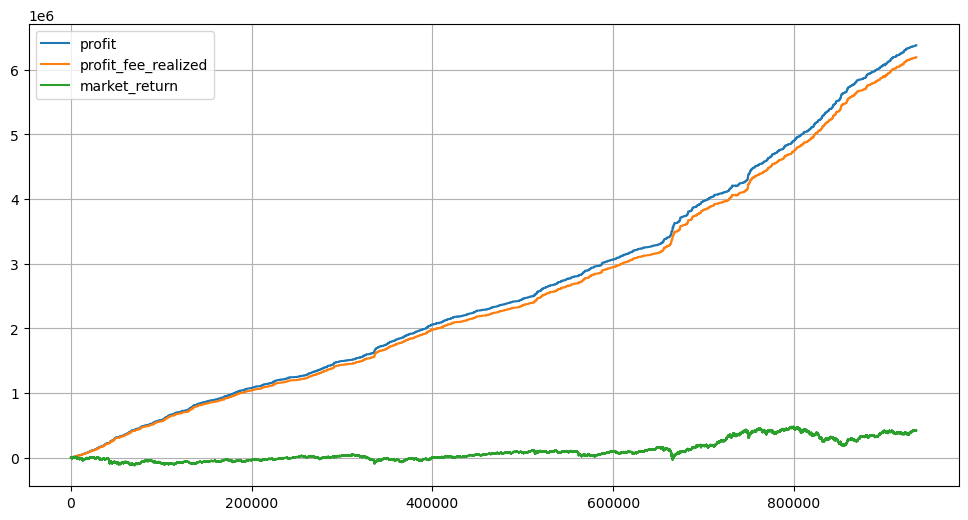

In [78]:
profit_series = []
profit_fee_series =[]

# 創建 Series，並使用原始 DataFrame 的索引進行對齊
profit_series = pd.Series(profit_dict)
profit_fee_series = pd.Series(profit_fee_dict)

# 確保索引與 df 的索引對齊，並填充缺失值為 0
aligned_profit = profit_series.reindex(df.index).fillna(0)
aligned_profit_fee = profit_fee_series.reindex(df.index).fillna(0)

#大盤累計報酬
df['Close_diff'] = df['Close'].diff()*50
df['Cumulative_diff'] = df['Close_diff'].cumsum()

# 生成包含對齊後數據的 DataFrame
equity = pd.DataFrame({
    'profit': aligned_profit.cumsum(),
    'profit_fee_realized': aligned_profit_fee.cumsum(),
    'market_return': df['Cumulative_diff'] 
})


# 繪製資本曲線
equity.plot(grid=True, figsize=(12, 6))


In [143]:
equity.to_excel('equity_data.xlsx', index=True)

In [79]:
# 計算交易勝率
total_trades = len(profit_fee_dict)  # 總交易數
winning_trades = sum(1 for profit in profit_fee_dict.values() if profit > 0)  # 獲利交易數
win_rate = winning_trades / total_trades if total_trades > 0 else 0  # 避免除以 0

# 顯示結果
print(f"交易總數: {total_trades}")
print(f"獲利交易數: {winning_trades}")
print(f"勝率: {win_rate:.2%}")

#計算夏普比率
avg_return = np.mean(profit_fee_list_realized)
std_return = np.std(profit_fee_list_realized)
risk_free_rate = 0.04  # 假設無風險利率為 0
sharpe_ratio = (avg_return - risk_free_rate) / std_return
print(f"Sharpe Ratio: {sharpe_ratio}")


交易總數: 2318
獲利交易數: 2198
勝率: 94.82%
Sharpe Ratio: 0.7654431764583615


In [81]:
# 計算每筆交易的持倉時間（出場索引 - 進場索引）
holding_times_short = [buytocover[i] - sellshort[i] for i in range(len(sellshort))] 
holding_times_long = [selltoover[i] - buylong[i] for i in range(len(buylong))] 
holding_times = holding_times_short + holding_times_long

# 使用 describe 來展示統計數值
holding_times_series = pd.Series(holding_times)
holding_times_series.describe()

holding_times_series.describe()


count    2405.000000
mean       25.347609
std        39.394657
min         1.000000
25%         1.000000
50%         5.000000
75%        37.000000
max       301.000000
dtype: float64

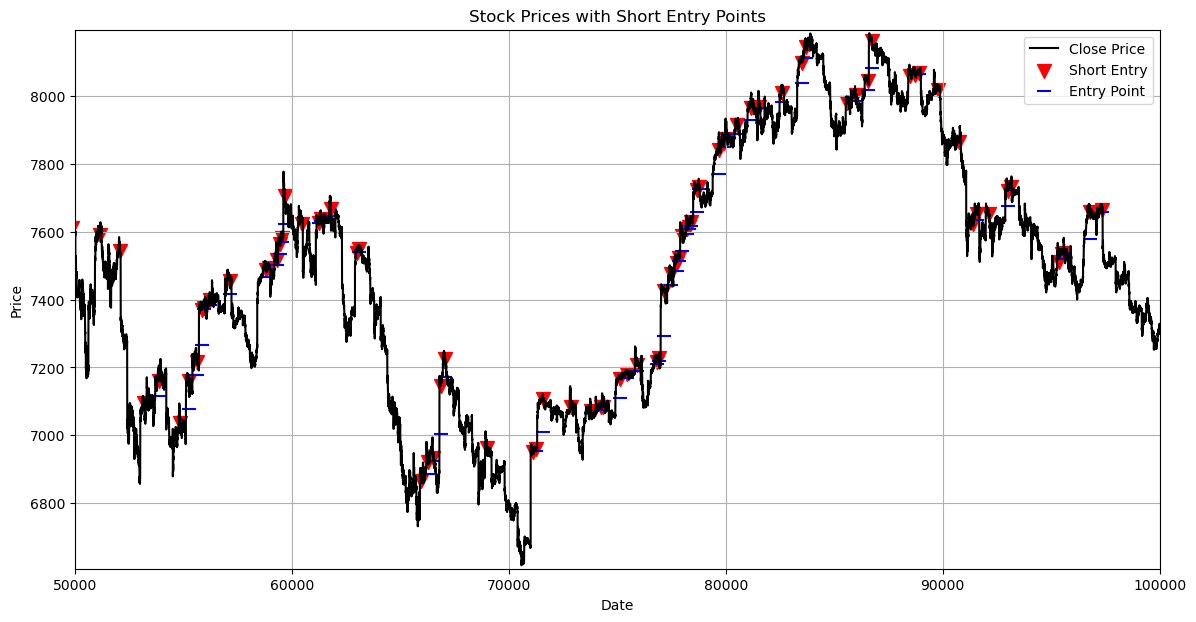

In [86]:
#標住Long Entry

# 繪製 Close 價格圖表
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='black')

# 標註 long_entry 的位置
long_entries = df[df['Trough_value'].notna()]
plt.scatter(long_entries.index, long_entries['Trough_value'], color='red', label='Short Entry', marker='v', s=100)

#標註掛單點
long_entries = df[df['calculated_long_entry'].notna()]
plt.scatter(long_entries.index, long_entries['calculated_long_entry'], color='blue', label='Entry Point', marker='_', s=100)

# 添加標題和圖例
plt.title('Stock Prices with Short Entry Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#限制觀察範圍
plt.xlim(50000,100000)
plt.ylim(min(df.loc[50000:100000, 'Close']) - 10, max(df.loc[50000:100000, 'Close']) + 10)

# 顯示圖表
plt.grid(True)
plt.show()

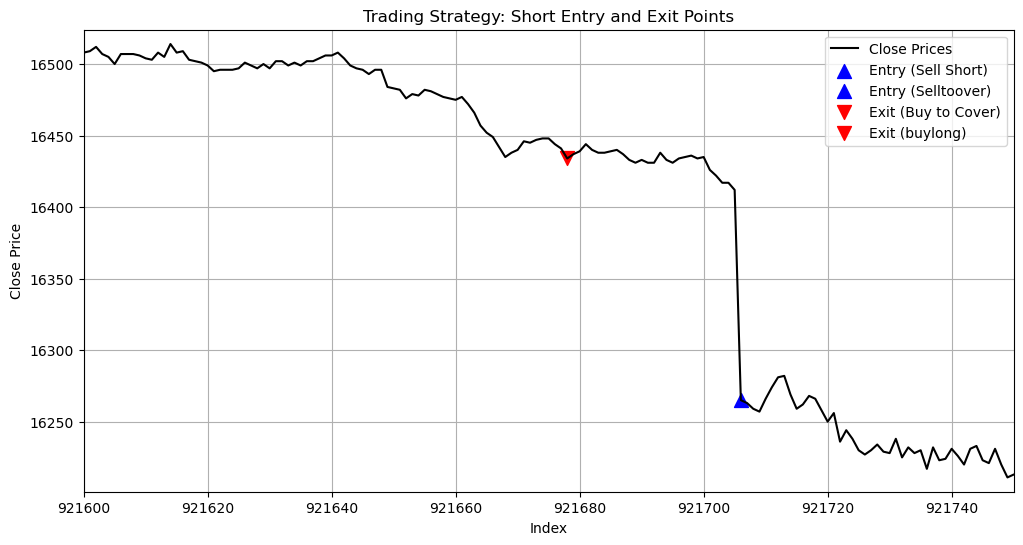

In [80]:
#標住進出場點
# 畫圖
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Prices', color='black')

# 標註做多點（藍色）
plt.scatter(sellshort, df.loc[sellshort, 'Close'], color='blue', label='Entry (Sell Short)', marker='^', s=100)
plt.scatter(selltoover, df.loc[selltoover, 'Close'], color='blue', label='Entry (Selltoover)', marker='^', s=100)

# 標註做空點（紅色）
plt.scatter(buytocover, df.loc[buytocover, 'Close'], color='red', label='Exit (Buy to Cover)', marker='v', s=100)
plt.scatter(buylong, df.loc[buylong, 'Close'], color='red', label='Exit (buylong)', marker='v', s=100)

# 添加圖例和標籤
plt.title('Trading Strategy: Short Entry and Exit Points')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

#限制觀察範圍
plt.xlim(921600, 921750)
plt.ylim(min(df.loc[921600:921750, 'Close']) - 10, max(df.loc[921600:921750, 'Close']) + 10)

# 顯示圖表
plt.show()


In [ ]:
from scipy import stats

# 計算策略的實現收益
profit_fee_list_realized = np.array(profit_fee_list_realized)

# 檢查是否有足夠的交易來進行檢驗
if len(profit_fee_list_realized) > 1:
    # 設定假設檢驗的零假設為：策略的平均收益等於0（即無顯著收益）
    t_statistic, p_value = stats.ttest_1samp(profit_fee_list_realized, 0)

    print(f"T-Statistic: {t_statistic}")
    print(f"P-Value: {p_value}")

    # 判斷是否拒絕零假設
    alpha = 0.05  # 顯著性水準（通常為0.05）
    if p_value < alpha:
        print("策略具有顯著性，收益顯著大於0")
    else:
        print("策略不具有顯著性，無法證明收益顯著大於0")
else:
    print("交易次數不足，無法進行 T 檢驗")

In [82]:
equity_curve = pd.Series(profit_fee_list_realized).cumsum()

# 計算最大回策 (MDD)
def MDD(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = equity_curve - cumulative_max
    max_drawdown = drawdown.min()
    return max_drawdown

max_drawdown = MDD(equity_curve)

# 如果需要以百分比顯示，可以如下進行轉換
max_drawdown_percentage = (max_drawdown / equity_curve.cummax().iloc[-1]) * 100
print(f"策略的MDD為: {max_drawdown_percentage:.2f}%")


策略的MDD為: -0.21%


In [15]:
equity.to_csv('equity.csv', index=False)

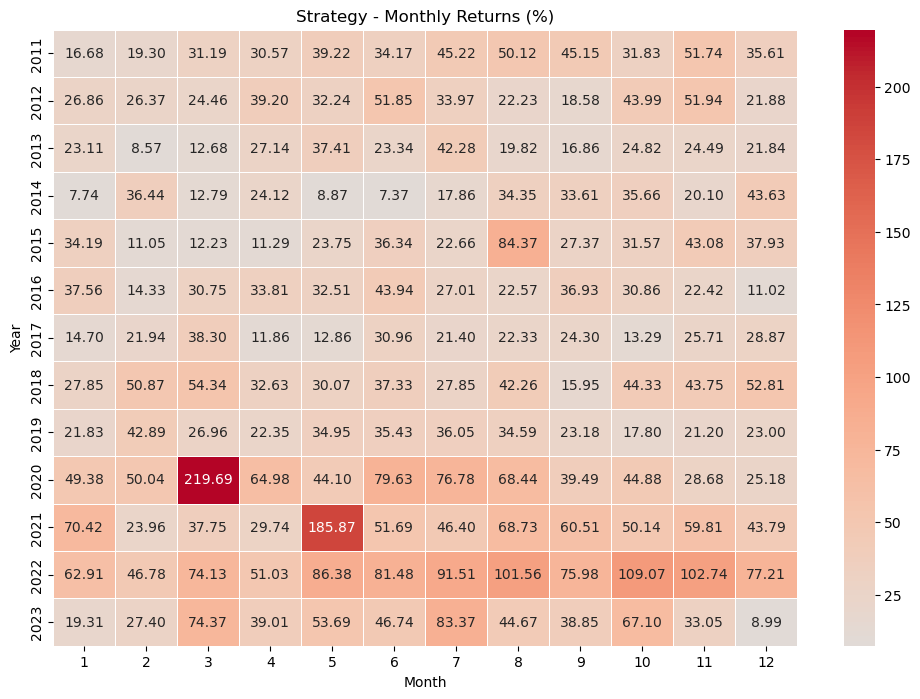

In [83]:
initial_capital = 100000  # 假設初始資金為 100,000
# 將損益轉換成 DataFrame 並包含日期資訊
profit_df = pd.DataFrame(list(profit_fee_dict.items()), columns=['Index', 'Profit_Fee'])
profit_df['Date'] = df.loc[profit_df['Index'], 'Date'].values

# 步驟1：提取年份和月份
profit_df['Year'] = pd.to_datetime(profit_df['Date']).dt.year
profit_df['Month'] = pd.to_datetime(profit_df['Date']).dt.month

# 步驟2：計算每月的總報酬
monthly_profit = profit_df.groupby(['Year', 'Month'])['Profit_Fee'].sum().reset_index()
monthly_profit['Profit_Fee'] = (monthly_profit['Profit_Fee'] / initial_capital) * 100

# 步驟3：將數據轉換成適合熱力圖的格式
heatmap_data = monthly_profit.pivot(index='Year', columns='Month', values='Profit_Fee')

# 步驟4：繪製熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('Strategy - Monthly Returns (%)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()